# AI_campus_ProstateSeg 
# Module 12: Hyper-Parameter Tuning of U-Net Prototype
### PANDA: Prostate cANcer graDe Assessment (PANDA) Challenge

In this module, we will implement automated hyper-parameter tuning using Optuna on the U-Net model that was prototyped in the previous module.

### 1. Import the necessary packages

In [53]:
import os
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import panda_utils as putil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import cv2
import optuna

from PIL import Image
from typing import List, Set, Union, Optional, Dict, Tuple
from torch.utils.data import Dataset, DataLoader
from dataclass import ToyPANDASDataset
from torchvision.transforms import functional as Fv
from scipy.stats import entropy
from normalizers import ChannelWiseMinMaxNormalizer
from sklearn.cluster import MeanShift
from sklearn.preprocessing import MinMaxScaler

### 2. Define folder and subdirectory folder names for training and testing image-mask pairs

In [2]:
# Define root folder
ROOT_FOLDER = "sample_data"

# Define training data folders for images and masks
TRAIN_IMAGE_SUBFOLDER = "train_images"
TRAIN_MASK_SUBFOLDER = "train_label_masks"

# Define test data folders for images and masks
TEST_IMAGE_SUBFOLDER = "test_images"
TEST_MASK_SUBFOLDER = "test_label_masks"

# Define train image and mask directory paths
train_image_dir = os.path.join(ROOT_FOLDER, TRAIN_IMAGE_SUBFOLDER)
train_mask_dir = os.path.join(ROOT_FOLDER, TRAIN_MASK_SUBFOLDER)

# Define test image and mask directory paths
test_image_dir = os.path.join(ROOT_FOLDER, TEST_IMAGE_SUBFOLDER)
test_mask_dir = os.path.join(ROOT_FOLDER, TEST_MASK_SUBFOLDER)

### 3. Create list of image and mask files and print contents for both the training and test set data

In [6]:
train_image_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(train_image_dir))))
train_mask_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(train_mask_dir))))

test_image_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(test_image_dir))))
test_mask_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(test_mask_dir))))

Print list of training set image files

In [7]:
train_image_files

['0018ae58b01bdadc8e347995b69f99aa.tiff',
 '004dd32d9cd167d9cc31c13b704498af.tiff',
 '0068d4c7529e34fd4c9da863ce01a161.tiff',
 '006f6aa35a78965c92fffd1fbd53a058.tiff',
 '007433133235efc27a39f11df6940829.tiff',
 '0076bcb66e46fb485f5ba432b9a1fe8a.tiff',
 '008069b542b0439ed69b194674051964.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb.tiff',
 '00951a7fad040bf7e90f32e81fc0746f.tiff',
 '00a26aaa82c959624d90dfb69fcf259c.tiff']

Print list of training set mask files. Each of these will have a "_mask.tiff" extension.

In [8]:
train_mask_files

['0018ae58b01bdadc8e347995b69f99aa_mask.tiff',
 '004dd32d9cd167d9cc31c13b704498af_mask.tiff',
 '0068d4c7529e34fd4c9da863ce01a161_mask.tiff',
 '006f6aa35a78965c92fffd1fbd53a058_mask.tiff',
 '007433133235efc27a39f11df6940829_mask.tiff',
 '0076bcb66e46fb485f5ba432b9a1fe8a_mask.tiff',
 '008069b542b0439ed69b194674051964_mask.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb_mask.tiff',
 '00951a7fad040bf7e90f32e81fc0746f_mask.tiff',
 '00a26aaa82c959624d90dfb69fcf259c_mask.tiff']

Print list of test set image files

In [9]:
test_image_files

['00a7fb880dc12c5de82df39b30533da9.tiff',
 '00bbc1482301d16de3ff63238cfd0b34.tiff',
 '00c15b23b30a5ba061358d9641118904.tiff',
 '00c46b336b5b06423fcdec1b4d5bee06.tiff',
 '00c52cb4db1c7a5811a8f070a910c038.tiff']

Print list of test set mask files. Each of these will have a "_mask.tiff" extension.

In [11]:
test_mask_files

['00a7fb880dc12c5de82df39b30533da9_mask.tiff',
 '00bbc1482301d16de3ff63238cfd0b34_mask.tiff',
 '00c15b23b30a5ba061358d9641118904_mask.tiff',
 '00c46b336b5b06423fcdec1b4d5bee06_mask.tiff',
 '00c52cb4db1c7a5811a8f070a910c038_mask.tiff']

### 4. Run function from module 1 to verify pair match, such that each image is coupled with a mask file for both the training and test set data

Verify pair match for training image and mask files

In [12]:
putil.verify_pair_match(image_dir = train_image_dir,
                        mask_dir = train_mask_dir)

True

Verify pair match for testing image and mask files

In [13]:
putil.verify_pair_match(image_dir = test_image_dir,
                        mask_dir = test_mask_dir)

True

### 5. Run function from module 1 to verify dimensionality match between image and mask files

Verify dimensionality match for training set image and mask files

In [14]:
putil.verify_dim_match(image_dir = train_image_dir,
                       mask_dir = train_mask_dir,
                       root_folder = ROOT_FOLDER,
                       image_subfolder = TRAIN_IMAGE_SUBFOLDER,
                       mask_subfolder = TRAIN_MASK_SUBFOLDER)

True

Verify dimensionality match for testing set image and mask files

In [15]:
putil.verify_dim_match(image_dir = test_image_dir,
                       mask_dir = test_mask_dir,
                       root_folder = ROOT_FOLDER,
                       image_subfolder = TEST_IMAGE_SUBFOLDER,
                       mask_subfolder = TEST_MASK_SUBFOLDER)

True

### 6. Run function from module 1 to validate the mask directory for both the training set and test set image data

Validate the training set mask files

In [16]:
putil.validate_mask_dir(mask_dir = train_mask_dir,
                        root_folder = ROOT_FOLDER,
                        mask_subfolder = TRAIN_MASK_SUBFOLDER)

True

Validate the test set mask files

In [17]:
putil.validate_mask_dir(mask_dir = test_mask_dir,
                        root_folder = ROOT_FOLDER,
                        mask_subfolder = TEST_MASK_SUBFOLDER)

True

### 7. Load and print the dimensionalities of the images and masks from the training and testing sets

Print the dimensionalities of the image files in the training set

In [18]:
for image_file in train_image_files:
    img = tifffile.imread(os.path.join(ROOT_FOLDER, TRAIN_IMAGE_SUBFOLDER, image_file))
    print(img.shape)

(25344, 5888, 3)
(22528, 8192, 3)
(10496, 6912, 3)
(7680, 2048, 3)
(24320, 9472, 3)
(14848, 11776, 3)
(8704, 23808, 3)
(36352, 10752, 3)
(8192, 11520, 3)
(20736, 18688, 3)


Print the dimensionalities of the mask files in the training set

In [19]:
for image_file in train_mask_files:
    img = tifffile.imread(os.path.join(ROOT_FOLDER, TRAIN_MASK_SUBFOLDER, image_file))
    print(img.shape)

(25344, 5888, 3)
(22528, 8192, 3)
(10496, 6912, 3)
(7680, 2048, 3)
(24320, 9472, 3)
(14848, 11776, 3)
(8704, 23808, 3)
(36352, 10752, 3)
(8192, 11520, 3)
(20736, 18688, 3)


Print the dimensionalities of the image files in the testing set

In [20]:
for image_file in test_image_files:
    img = tifffile.imread(os.path.join(ROOT_FOLDER, TEST_IMAGE_SUBFOLDER, image_file))
    print(img.shape)

(4352, 32256, 3)
(26624, 5120, 3)
(36352, 8704, 3)
(31744, 4096, 3)
(23296, 9984, 3)


Print the dimensionalities of the mask files in the testing set

In [21]:
for image_file in test_mask_files:
    img = tifffile.imread(os.path.join(ROOT_FOLDER, TEST_MASK_SUBFOLDER, image_file))
    print(img.shape)

(4352, 32256, 3)
(26624, 5120, 3)
(36352, 8704, 3)
(31744, 4096, 3)
(23296, 9984, 3)


### 8. Re-write dataset class to load both images and masks in a tile by tile manner

The initial dataset class written in the fourth module did not return masks. Since we are setting up a pipeline for supervised machine learning, we will write another class that iterates over the images in a tile by tile manner and returns the tile alongside its corresponding mask

In [82]:
class ToyPANDASDataset(Dataset):
    
    def __init__(self,
                 image_dir: str,
                 mask_dir: str, 
                 root_dir: str,
                 mask_suffix: str = "_mask",
                 imfile_ext: str = ".tiff",
                 maskfile_ext: str = ".tiff",
                 tile_size: int = 224,
                 channel_idx: int = 0,
                 min_thresh: float = 0.5,
                 transform = None,
                 norm_func = None):
        
        """
        Dataset class for Toy PANDA dataset of 10 images and masks.
        
        Parameters
        -----------
        image_dir: str
            The directory containing the images. 
        
        mask_dir: str
            The directory containing the masks paired with each of the images. 
        
        root_dir: str
            The root directory containing both the image and mask folders.
        
        mask_suffix: str
            The suffix associated with mask files in the folder. In this case,
            it is "_mask." Each image is labeled alphanumerically, and its corresponding
            mask file has a "_mask" suffix following the alphanumeric name. 
        
        imfile_ext: str
            The extension or file type of the image file. In this case, it is ".tiff"
            
        maskfile_ext: str
            The extension or file type of the mask file. In this case, it is ".tiff"
        
        tile_size: int
            The size of the square tiles to extract from images in a non-overlapping way.
            Each tile extarcted from the image will contain (tile_size ** 2) number of pixels.
        
        channel_idx: int
            Since the masks in this PANDA dataset contain 3 channels. This constant indicates
            the location of the official, 2 by 2 mask in the 3 channel mask tensor. Default
            value is 0. 
        
        min_thresh: float
            This constant sets a criteria for tile qualification. A tile is only qualified to
            be positively filtered for the dataset if it containts signal (% of foreground of all pixels)
            that is more than or equal to min_thresh.
        
        transform: Optional[None, function]
            This object stores None or a function. If it is a function, this function is applied
            to the data before being returned by the get item dunder method. This transform could
            contain a normalization function or it could contain a series of augmentation steps
            applied before returning an image. 
        
        norm_func: Optional[None, function]
            Function to normalize a tile depending on certain pre-defined 
            min-max statistics (for min max normalization) or z-score normalization
            depending on pre-defined statistics for the mean and standard deviation. 
        
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.root_dir = root_dir
        self.mask_suffix = mask_suffix
        self.imfile_ext = imfile_ext
        self.maskfile_ext = maskfile_ext
        self.transform = transform
        self.norm_func = norm_func
        self.tile_size = tile_size
        self.full_mask_ext = self.mask_suffix + self.maskfile_ext
        self.channel_idx = channel_idx
        self.image_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(self.image_dir))))[:1]
        self.mask_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(self.mask_dir))))[:1]
        self.n_tiles_processed = 0
        self.n_qualifying_tiles = 0
        self.min_thresh = min_thresh
        self.imtile_coords = self.get_imtile_coords()
        
    def extract_raw_regid(self,
                          filename: str,
                          ext: str) -> str:
        """
        This function receives a filename which a specific
        extension like "_mask.tiff" or ".tiff", then it processes
        and returns the part of the filename up until but excluding
        the extension. 
        
        Parameters
        -----------
        filename: str
            The filename, with the name and extension as a suffix
        
        ext: str
            The extension
        
        Returns
        ----------
        The filename up until but excluding the extension
        
        """
        i = 1
        while filename[-i:] != ext:
            i += 1
        return filename[0:len(filename)-i]
    
    def tile_qualifier(self,
                       tile_mask: np.ndarray):
        """
        A tile qualifier function. This function
        receives a mask extracted from a tile. The mask
        can be binary or it could be multi-class,
        representing presence of multiple different classes
        indicated by integer values greater than or equal to 1. 
        The background (non-signal) region should be represented
        by 0. This function checks if the mask contains a minimum
        threshold of signal, as represented by the number of non-zero
        values as a percentage of the total number of pixels in the
        tile. 
        
        Parameters
        -----------
        tile_mask: np.ndarray
            A tile (square or rectangular) as a numpy array,
            containing integer values greater than or equal to 0.
        
        Returns
        ---------
        bool
            Whether the tile qualifies or not.
            Whether its signal ratio meets the minimum
            threshold requirement for it to qualify
            to be included in the dataset. 
            
        """
        
        signal_ratio = (tile_mask > 0).sum()/tile_mask.size
        
        return signal_ratio >= self.min_thresh
    
    def extract_nonoverlapping_tile_coords(self,
                                           mask: np.ndarray):
        
        """
        This function extracts nonoverlapping tile coordinates
        from a mask according to the tile_size. It collects
        the coordinates of the top left corner of each tile and 
        then returns it. 
        
        Paramters
        ---------
        mask: np.ndarray
            A mask of arbitrary shape. Containing 3 or more
            channels, but only the 0th channel is used as the
            official, signal indicating channel for extracting 
            tile coordinates.
        
        Returns
        --------
        List[Tuple[int, int]]
            A list of coordinates stored in tuples of size 2.
            These are coordinates of tiles that qualify according
            to the tile qualifier function. 
        """
        
        mask = mask[:,:,self.channel_idx]
        assert len(mask.shape) == 2
        R, C = mask.shape
        tile_coords = []
        for i in range(0, R, self.tile_size):
            for j in range(0, C, self.tile_size):
                try:
                    tile = mask[i : i + self.tile_size, j : j + self.tile_size]
                    self.n_tiles_processed += 1
                    if tile.shape == (self.tile_size, self.tile_size) and self.tile_qualifier(tile):
                        tile_coords.append((i, j))
                        self.n_qualifying_tiles += 1
                except IndexError:
                    print(f"Skipping tile at position ({i}, {j}) because it is out of bounds.")
                        
        return tile_coords
    
    def get_imtile_coords(self):
        
        """
        Function to process the images and return a list of 
        3-sized tuples that contain the name of the image file
        along with coordinates of qualifying tiles in them.
        The image file names can be repeated in tuples, but not
        the coordinate of the tiles.
        
        Parameters
        -----------
        None, all objects used are instantiated in the constructor.
        
        Returns
        -----------
        List[Tuple[str, in, int]]
            A list of tuples. The first value in the tuple is
            the name of the image file. The second and third
            values in the tuples are coordinates of one of the
            qualifying tiles in the image.
            
        """
        
        imtile_coords = []
        
        for imfile in self.image_files:
            regid = self.extract_raw_regid(imfile, self.imfile_ext)
            mask_file = regid + self.full_mask_ext
            mask = tifffile.imread(os.path.join(self.mask_dir, mask_file))
            tile_coords = self.extract_nonoverlapping_tile_coords(mask)
            imtile_coord = list(map(lambda tup : (imfile,) + tup, tile_coords))
            imtile_coords.extend(imtile_coord)
            
        self.tile_qualifying_ratio = self.n_qualifying_tiles / self.n_tiles_processed
        print(f"Total number of tiles processed: {self.n_tiles_processed}")
        print(f"Tile qualifying ratio: {round(self.tile_qualifying_ratio,2)}")
        print(f"Average number of tiles processed per image or mask: {self.n_tiles_processed/len(self.image_files)}")
        print(f"Average number of tiles qualifying per image or mask: {self.n_qualifying_tiles/len(self.image_files)}")
        
        imfiles = set([t[0] for t in imtile_coords])
        assert imfiles == set(self.image_files)
        i_vals = sorted(list(set([t[1] for t in imtile_coords])))
        j_vals = sorted(list(set([t[2] for t in imtile_coords])))
        """
        for i in range(len(i_vals)-1):
            assert i_vals[i + 1] - i_vals[i] == self.tile_size
        
        for j in range(len(j_vals)-1):
            assert j_vals[j + 1] - j_vals[j] == self.tile_size
        """
        return imtile_coords
        
    def __len__(self):
        
        """
        Dunder method to return the length of the
        dataset. The total length of the dataset 
        is the total number of tiles over all 
        of the images. Some images may provide more
        tiles to the dataset depending on their signal
        content, while other images may provide less
        tiles if they are weak in signal.
        """
        
        return len(self.imtile_coords)
    
    def __getitem__(self, idx):
        
        """
        Function for getting a tile from the dataset.
        Given an index, it finds a tuple in the imtile_coords
        and unpacks it to retrieve the image file and the coordinates
        of one of the qualifying tiles in the image. 
        """
        
        image_file, tile_i, tile_j = self.imtile_coords[idx]
        image = tifffile.imread(os.path.join(self.image_dir, image_file))
        tile = image[tile_i: tile_i + self.tile_size, tile_j: tile_j + self.tile_size, :]
        regid = self.extract_raw_regid(image_file, self.imfile_ext)
        mask_file = regid + self.full_mask_ext
        mask = tifffile.imread(os.path.join(self.mask_dir, mask_file))
        mask = mask[:,:,self.channel_idx]
        tile_mask = mask[tile_i: tile_i + self.tile_size, tile_j: tile_j + self.tile_size]
        
        if self.transform:
            tile = self.transform(tile)
        
        if self.norm_func:
            tile = torch.tensor(tile)
            tile = tile.unsqueeze(0).permute(0, 3, 1, 2)
            tile = self.norm_func(tile)
            tile = tile.squeeze(0).permute(1,2,0)
            
        return tile, tile_mask

In [83]:
min_vals = torch.tensor([0, 0, 0])
max_vals = torch.tensor([255, 255, 255])

normalizer = ChannelWiseMinMaxNormalizer(min_values = min_vals,
                                         max_values = max_vals)

We have the following directories available for training and testing image and mask files:

- train_image_dir
- train_mask_dir

- test_image_dir
- test_mask_dir

### 9. Instantiate a DataLoader and start an iterator over the batch. While instantiating the DataLoader, pass the normalizer's transform function into the Dataset class

In [84]:
train_dataset = ToyPANDASDataset(image_dir = train_image_dir,
                                 mask_dir = train_mask_dir,
                                 root_dir = ROOT_FOLDER,
                                 norm_func = normalizer.transform,
                                 min_thresh = 0.9999)

print("\n")

test_dataset = ToyPANDASDataset(image_dir = test_image_dir,
                                mask_dir = test_mask_dir,
                                root_dir = ROOT_FOLDER,
                                norm_func = normalizer.transform,
                                min_thresh = 0.9999)

test_dataset_raw = ToyPANDASDataset(image_dir = test_image_dir,
                                    mask_dir = test_mask_dir,
                                    root_dir = ROOT_FOLDER,
                                    min_thresh = 0.9999)

Total number of tiles processed: 3078
Tile qualifying ratio: 0.14
Average number of tiles processed per image or mask: 3078.0
Average number of tiles qualifying per image or mask: 438.0


Total number of tiles processed: 2880
Tile qualifying ratio: 0.25
Average number of tiles processed per image or mask: 2880.0
Average number of tiles qualifying per image or mask: 733.0
Total number of tiles processed: 2880
Tile qualifying ratio: 0.25
Average number of tiles processed per image or mask: 2880.0
Average number of tiles qualifying per image or mask: 733.0


In [110]:
print(f"Length of the training dataset: {len(train_dataset)}")

Length of the training dataset: 438


In [111]:
print(f"Length of the testing dataset: {len(test_dataset)}")

Length of the testing dataset: 733


In [87]:
train_loader = DataLoader(train_dataset, batch_size = 24, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 24, shuffle = False)
test_loader_raw = DataLoader(test_dataset_raw, batch_size = 24, shuffle = False)

In [88]:
print(f"Number of batches present in the train_loader: {len(train_loader)}")
print(f"Number of batches present in the test_loader: {len(test_loader)}")

Number of batches present in the train_loader: 19
Number of batches present in the test_loader: 31


In [89]:
train_iter = iter(train_loader)
test_iter = iter(test_loader)
test_iter_raw = iter(test_loader_raw)

In [90]:
train_images, train_masks = next(train_iter)

In [91]:
train_images.shape

torch.Size([24, 224, 224, 3])

In [92]:
train_masks.shape

torch.Size([24, 224, 224])

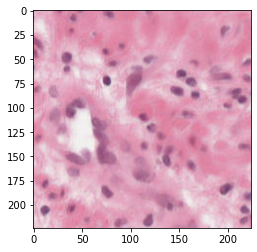

In [93]:
plt.imshow(train_images[0])

In [94]:
putil.enlist_class_presence(train_masks[0])

array([1, 2], dtype=uint8)

In [95]:
putil.summarize_class_distribution(train_masks[0].numpy())

{1: 0.94, 2: 0.06}

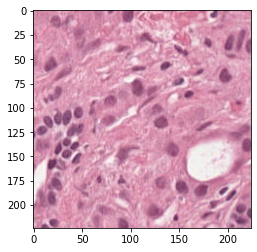

In [96]:
plt.imshow(train_images[-1])

In [97]:
putil.enlist_class_presence(train_masks[-1])

array([1, 4], dtype=uint8)

In [98]:
putil.summarize_class_distribution(train_masks[-1].numpy())

{1: 0.39, 4: 0.61}

In [99]:
test_images, test_masks = next(test_iter)

In [100]:
test_images.shape

torch.Size([24, 224, 224, 3])

In [101]:
test_masks.shape

torch.Size([24, 224, 224])

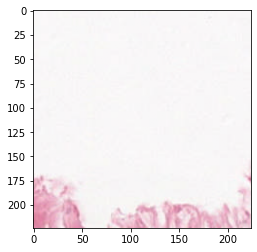

In [102]:
plt.imshow(test_images[0])

In [103]:
putil.enlist_class_presence(test_masks[0])

array([1], dtype=uint8)

In [104]:
putil.summarize_class_distribution(test_masks[0].numpy())

{1: 1.0}

In [105]:
test_images_raw, test_masks_raw = next(test_iter_raw)

Write basic U-Net model for semantic segmentation. The model will take as input the number of input channels (default = 3) and it will also take as input the number of classes, which is 6. The model will translate a tensor of shape [B, 3, H, W] to a tensor of shape [B, 6, H, W]. This will output a probability distribution over the six possible classes for each pixel in the image. 

In [106]:
class UNet(nn.Module):
    def __init__(self, 
                 in_channels=3, 
                 num_classes=6):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        def up_block(in_ch, out_ch):
            return nn.Sequential(
                nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.up4 = up_block(1024, 512)
        self.dec4 = conv_block(1024, 512)
        self.up3 = up_block(512, 256)
        self.dec3 = conv_block(512, 256)
        self.up2 = up_block(256, 128)
        self.dec2 = conv_block(256, 128)
        self.up1 = up_block(128, 64)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        up4 = self.up4(bottleneck)
        dec4 = self.dec4(torch.cat([up4, enc4], dim=1))
        up3 = self.up3(dec4)
        dec3 = self.dec3(torch.cat([up3, enc3], dim=1))
        up2 = self.up2(dec3)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))
        up1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))

        return self.final(dec1)

In [112]:
def objective(trial):
    
    batch_size = trial.suggest_int('batch_size', 16, 64)
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    num_epochs = 2
    
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
    
    unet = UNet()
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(unet.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        unet.train()
        
        for batch_idx, (images, masks) in enumerate(train_loader):
            reordered_images = images.permute(0, 3, 1, 2)
            optimizer.zero_grad()
            output = unet(reordered_images)
            loss = loss_fn(output, masks.long())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_epoch_loss = epoch_loss / len(train_loader)
        print(f"Epoch: {epoch}, epoch_train_loss: {avg_epoch_loss}")
    
    unet.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(test_loader):
            reordered_images = images.permute(0, 3, 1, 2)
            output = unet(reordered_images)
            loss = loss_fn(output, masks.long())
            test_loss += loss.item()
        test_loss /= len(test_loader)
    
    return test_loss

In [114]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

Once Optuna study runs, plug in optimal values for batch size and learning rate to new model training. Explore alternative Optuna studies by subjecting other hyper-parameters like CNN kernel size to search process in trial's suggestions. Then, plot ground truth and predicted segmentation mask results from models trained under different hyper-parameter settings. 